In [ ]:
!pip install sentencepiece
!pip install openpyxl

In [ ]:
import os
from PIL import Image
import requests
import torch
# from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import numpy as np

# Download Data

In [ ]:
!git clone https://github.com/carlosgarciahe/ms-coco-es

# Clone the Modified Model

In [ ]:
git_token = "Your Personal Access Token from Georgia Tech Github Enterprise"

In [ ]:
!git clone https://{git_token}@github.gatech.edu/tpang34/XLM_CLIP.git

In [ ]:
# install the modified CLIP
!pip install XLM_CLIP/transformers_mod/.

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel, CLIPProcessor, CLIPModel


# Demo of the modified XLM-CLIP

In [ ]:
device = 'cuda'
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")# .to(device)


In [ ]:

url1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
image1 = Image.open(requests.get(url1, stream=True).raw)

url2 = "http://images.cocodataset.org/test-stuff2017/000000002383.jpg"
image2 = Image.open(requests.get(url2, stream=True).raw)

text1 =  "a photo of a cat" # "una foto de un gato" 
text2 = "a photo of two zebra"

xlm_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")# .to(device)
xlm_inputs = xlm_tokenizer([text1], return_tensors="pt").to(device)

clip_inputs = clip_processor(
    text=[text1], images=[image1, image2, image1], return_tensors="pt", padding=True
).to(device)



Downloading: 0%| | 0.00/5.07M [00:00<?, ?B/s]

In [ ]:
outputs = clip_model(xlm_inputs=xlm_inputs, **clip_inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=0)  # we can take the softmax to get the label probabilities


In [ ]:
probs

Out[12]: tensor([[0.4887],
 [0.0226],
 [0.4887]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training

In [ ]:
# freezing all other layers
for param in clip_model.parameters():
    param.requires_grad = False
clip_model.agg_text_projection.requires_grad_(True)

Out[13]: Linear(in_features=1536, out_features=512, bias=False)

In [ ]:
optimizer_config = {
  "optimizer_type": "AdamW",
  "lr": 1e-2,
  "weight_decay": 0,
  "momentum": None}

In [ ]:
spark.sparkContext.addPyFile("/databricks/driver/XLM_CLIP/utils.py")
spark.sparkContext.addPyFile("/databricks/driver/XLM_CLIP/trainer_fx.py")
from trainer_fx import Trainer, get_optimizer

In [ ]:
is_cuda = torch.cuda.is_available()
print("Have GPU?: ", is_cuda)

optimizer = get_optimizer(clip_model, optimizer_config)
local_path = "/databricks/driver/"
dbfs_path = "/dbfs/FileStore/xlm_clip"
dbfs_path_dbutil = "dbfs:/FileStore/xlm_clip"

data_dir = os.path.join(local_path, "ms-coco-es")
model_base_path = os.path.join(dbfs_path, 'clip_checkpoints') 
model_base_path_dbutil = os.path.join(dbfs_path_dbutil, 'clip_checkpoints') 


dbutils.fs.mkdirs(model_base_path_dbutil)
print("Model Checkpoints Directory ready? ", os.path.isdir(model_base_path))

Have GPU?: True
Model Checkpoints Directory ready? True

In [ ]:
trainer = Trainer(data_dir= data_dir, 
                  model = clip_model,
                  optimizer = optimizer,
                  model_dir = model_base_path,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [ ]:
trainer.train(num_epochs=50)

Epoch:0, Training Loss:2.3360, Validation Loss:2.3284
Epoch:1 | Training Loss:1.7560, Validation Loss:1.8517 | Training Recall@5:0.9770, Validation Recall@5:0.9540
Epoch:2 | Training Loss:1.6543, Validation Loss:1.7638 | Training Recall@5:0.9917, Validation Recall@5:0.9650
Epoch:3 | Training Loss:1.6097, Validation Loss:1.7080 | Training Recall@5:0.9947, Validation Recall@5:0.9730
Epoch:4 | Training Loss:1.5992, Validation Loss:1.6863 | Training Recall@5:0.9940, Validation Recall@5:0.9880
Epoch:5 | Training Loss:1.5838, Validation Loss:1.6850 | Training Recall@5:0.9957, Validation Recall@5:0.9830
Epoch:6 | Training Loss:1.5747, Validation Loss:1.6507 | Training Recall@5:0.9952, Validation Recall@5:0.9890
Epoch:7 | Training Loss:1.5524, Validation Loss:1.6578 | Training Recall@5:0.9970, Validation Recall@5:0.9940
Epoch:8 | Training Loss:1.5523, Validation Loss:1.6212 | Training Recall@5:0.9975, Validation Recall@5:0.9940
Epoch:9 | Training Loss:1.5471, Validation Loss:1.6423 | Training Recall@5:0.9970, Validation Recall@5:0.9890
Epoch:10 | Training Loss:1.5395, Validation Loss:1.6093 | Training Recall@5:0.9980, Validation Recall@5:0.9960
Epoch:11 | Training Loss:1.5422, Validation Loss:1.6131 | Training Recall@5:0.9972, Validation Recall@5:0.9950
Epoch:12 | Training Loss:1.5417, Validation Loss:1.6318 | Training Recall@5:0.9992, Validation Recall@5:0.9910
Epoch:13 | Training Loss:1.5331, Validation Loss:1.6211 | Training Recall@5:0.9980, Validation Recall@5:0.9920
Epoch:14 | Training Loss:1.5382, Validation Loss:1.6219 | Training Recall@5:0.9990, Validation Recall@5:0.9910
Epoch:15 | Training Loss:1.5335, Validation Loss:1.6228 | Training Recall@5:0.9985, Validation Recall@5:0.9870
Epoch:16 | Training Loss:1.5192, Validation Loss:1.6056 | Training Recall@5:0.9987, Validation Recall@5:0.9920
Epoch:17 | Training Loss:1.5202, Validation Loss:1.6038 | Training Recall@5:0.9987, Validation Recall@5:0.9990
Epoch:18 | Training Loss:1.5231, Validation Loss:1.6082 | Training Recall@5:0.9987, Validation Recall@5:0.9950
Epoch:19 | Training Loss:1.5170, Validation Loss:1.6109 | Training Recall@5:0.9977, Validation Recall@5:0.9950
Epoch:20 | Training Loss:1.5249, Validation Loss:1.6030 | Training Recall@5:0.9980, Validation Recall@5:0.9950
Epoch:21 | Training Loss:1.5149, Validation Loss:1.6138 | Training Recall@5:0.9985, Validation Recall@5:0.9940
Epoch:22 | Training Loss:1.5222, Validation Loss:1.6099 | Training Recall@5:0.9982, Validation Recall@5:0.9960
Epoch:23 | Training Loss:1.5103, Validation Loss:1.5768 | Training Recall@5:0.9992, Validation Recall@5:0.9980
Epoch:24 | Training Loss:1.5144, Validation Loss:1.5909 | Training Recall@5:0.9995, Validation Recall@5:0.9960
Epoch:25 | Training Loss:1.5103, Validation Loss:1.5826 | Training Recall@5:1.0000, Validation Recall@5:0.9980
Epoch:26 | Training Loss:1.5120, Validation Loss:1.5989 | Training Recall@5:0.9995, Validation Recall@5:0.9960
Epoch:27 | Training Loss:1.5175, Validation Loss:1.5926 | Training Recall@5:0.9995, Validation Recall@5:0.9990
Epoch:28 | Training Loss:1.5095, Validation Loss:1.5827 | Training Recall@5:0.9997, Validation Recall@5:0.9970
Epoch:29 | Training Loss:1.5111, Validation Loss:1.5975 | Training Recall@5:0.9995, Validation Recall@5:0.9920
Epoch:30 | Training Loss:1.5062, Validation Loss:1.5826 | Training Recall@5:0.9997, Validation Recall@5:0.9930
Epoch:31 | Training Loss:1.5114, Validation Loss:1.5890 | Training Recall@5:0.9990, Validation Recall@5:0.9930
Epoch:32 | Training Loss:1.5034, Validation Loss:1.5707 | Training Recall@5:0.9995, Validation Recall@5:0.9990
Epoch:33 | Training Loss:1.5059, Validation Loss:1.5869 | Training Recall@5:0.9997, Validation Recall@5:0.9970
Epoch:34 | Training Loss:1.4985, Validation Loss:1.5706 | Training Recall@5:0.9997, Validation Recall@5:0.9940
Epoch:35 | Training Loss:1.5075, Validation Loss:1.5848 | Training Recall@5:0.9992, Validation Recall@5:0.9960
Epoch:36 | Training Loss:1.5033, Validation Loss:1.5782 | Training Rec

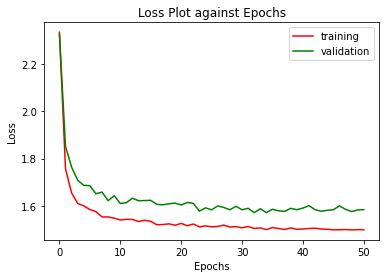

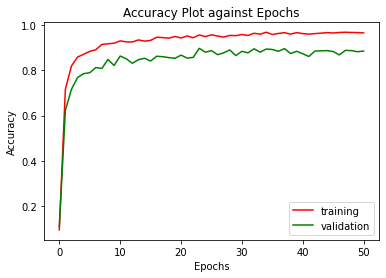

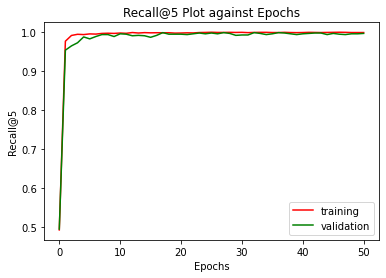

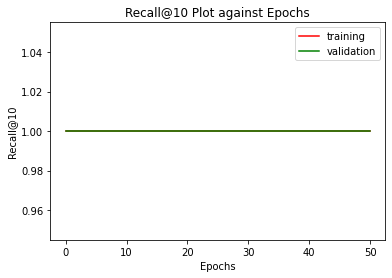

In [ ]:
trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_recall5()
trainer.plot_recall10()

In [ ]:
trainer.save_model("final_checkpoint.pt")

In [ ]:
test_loss, test_acc, test_recall5, test_recall10 = trainer.evaluate(split='test')
test_loss, test_acc, test_recall5, test_recall10

Out[21]: (1.5746493563876376, 0.8958958958958959, 0.994994994994995, 1.0)

In [ ]:
trainer.train_accuracy_list

Out[22]: [0.09384384384384384,
 0.7174674674674675,
 0.8198198198198198,
 0.8593593593593594,
 0.8716216216216216,
 0.8846346346346347,
 0.8918918918918919,
 0.9151651651651652,
 0.9181681681681682,
 0.9206706706706707,
 0.9309309309309309,
 0.9266766766766766,
 0.9261761761761762,
 0.9351851851851852,
 0.92992992992993,
 0.9331831831831832,
 0.9471971971971972,
 0.9454454454454454,
 0.9429429429429429,
 0.9504504504504504,
 0.943943943943944,
 0.9527027027027027,
 0.944944944944945,
 0.9572072072072072,
 0.94994994994995,
 0.9579579579579579,
 0.9524524524524525,
 0.9476976976976977,
 0.9552052052052052,
 0.9542042042042042,
 0.9592092092092092,
 0.954954954954955,
 0.9647147147147147,
 0.9607107107107107,
 0.9692192192192193,
 0.9592092092092092,
 0.963963963963964,
 0.9672172172172172,
 0.960960960960961,
 0.9674674674674675,
 0.9632132132132132,
 0.960960960960961,
 0.9632132132132132,
 0.9652152152152152,
 0.9674674674674675,
 0.965965965965966,
 0.9682182182182182,
 0.9692192192192193,
 0.9682182182182182,
 0.9677177177177178,
 0.9662162162162162]

In [ ]:
trainer.validation_accuracy_list

Out[23]: [0.10810810810810811,
 0.6236236236236237,
 0.7167167167167167,
 0.7687687687687688,
 0.7857857857857858,
 0.7897897897897898,
 0.8128128128128128,
 0.8088088088088088,
 0.8488488488488488,
 0.8218218218218218,
 0.8638638638638638,
 0.8518518518518519,
 0.8318318318318318,
 0.8478478478478478,
 0.8538538538538538,
 0.8418418418418419,
 0.8628628628628628,
 0.8608608608608609,
 0.8568568568568569,
 0.8538538538538538,
 0.8678678678678678,
 0.8548548548548549,
 0.8578578578578578,
 0.8978978978978979,
 0.8808808808808809,
 0.8878878878878879,
 0.8698698698698699,
 0.8778778778778779,
 0.8908908908908909,
 0.8658658658658659,
 0.8848848848848849,
 0.8778778778778779,
 0.8958958958958959,
 0.8808808808808809,
 0.8948948948948949,
 0.8928928928928929,
 0.8848848848848849,
 0.8968968968968969,
 0.8748748748748749,
 0.8848848848848849,
 0.8738738738738738,
 0.8618618618618619,
 0.8858858858858859,
 0.8868868868868869,
 0.8878878878878879,
 0.8838838838838838,
 0.8688688688688688,
 0.8888888888888888,
 0.8878878878878879,
 0.8828828828828829,
 0.8858858858858859]

## Sample Size = 50

In [ ]:
trainer_50 = Trainer(data_dir= data_dir, 
                  model = clip_model,
                  optimizer = optimizer,
                  model_dir = model_base_path,
                  negative_sample_k=49,
                  load_from_disk = True,
                  checkpoint_name = "final_checkpoint.pt",
                  cuda = is_cuda
                 )

In [ ]:
test_loss, test_acc, test_recall5, test_recall10 = trainer_50.evaluate(split='test')
test_loss, test_acc, test_recall5, test_recall10

Out[27]: (3.2964443936123624, 0.6636636636636637, 0.9579579579579579, 0.982982982982983)

## Sample Size = 100

In [ ]:
trainer_100 = Trainer(data_dir= data_dir, 
                  model = clip_model,
                  optimizer = optimizer,
                  model_dir = model_base_path,
                  negative_sample_k=99,
                  load_from_disk = True,
                  checkpoint_name = "final_checkpoint.pt",
                  cuda = is_cuda
                 )

In [ ]:
test_loss, test_acc, test_recall5, test_recall10 = trainer_100.evaluate(split='test')
test_loss, test_acc, test_recall5, test_recall10

Out[36]: (4.076198268581081, 0.5705705705705706, 0.9179179179179179, 0.9719719719719719)

## Sample Size = 150

In [ ]:
trainer_150 = Trainer(data_dir= data_dir, 
                  model = clip_model,
                  optimizer = optimizer,
                  model_dir = model_base_path,
                  negative_sample_k=149,
                  load_from_disk = True,
                  checkpoint_name = "final_checkpoint.pt",
                  cuda = is_cuda
                 )

In [ ]:
test_loss, test_acc, test_recall5, test_recall10 = trainer_150.evaluate(split='test')
test_loss, test_acc, test_recall5, test_recall10

Out[34]: (4.570674189814815, 0.47647647647647645, 0.8788788788788788, 0.938938938938939)